# COVID-19 - How long until herd immunity?
> Everyone would like to know when this pandemic will end. Herd immunity is a possible scenario in which the pandemic ends by immunizing the population if we don't find a vaccine. But how long do we have to wait until we're there?

- comments: true
- author: Caglar Cakan
- categories: [covid19]
- permalink: /covid-herd-immunity/
- image: images/icon_herd_immunity.png
- license: Creative Commons

In [1]:
#hide_input
import datetime
print("This page was last built on", datetime.datetime.now().strftime("%d.%m.%y %H:%M:%S"))

This page was last built on 03.05.20 01:12:34


It seems like there are only two realistic scenarios when we think about how the Corona pandemic could end. 

In the first scenario, we find a vaccine and reach wide-spread immunity on a global scale. This could take one year or maybe two and could be the better strategy when we look at scenario number two:

In this scenario we reach herd immunity and most of the population has antibodies for the Corona virus. The threshold for herd immunity for the Corona virus is estimated to be around 60% of the global population.

Please note that "confirmed cases" are known to grossly underestimate the number of people with antibodies. [Recent numbers](https://www.cnbc.com/2020/04/23/new-york-antibody-study-estimates-13point9percent-of-residents-have-had-the-coronavirus-cuomo-says.html) (23.04.2020) seem to indicate that up to 13.9% of NYC citizens could have antibodies although the number of confirmed cases is at around 5% of the population.

In [2]:
#hide
import numpy as np

import datetime

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates

import requests
import io

from countryinfo import CountryInfo

sns.set_context('talk')
plt.style.use('ggplot')

In [3]:
#hide
def load_timeseries(name, 
                    base_url='https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series'):
    import requests
    # Thanks to kasparthommen for the suggestion to directly download
    url = f'{base_url}/time_series_covid19_{name}_global.csv'
    csv = requests.get(url).text
    df = pd.read_csv(io.StringIO(csv), 
                     index_col=['Country/Region', 'Province/State', 'Lat', 'Long'])
    df['type'] = name.lower()
    df.columns.name = 'date'

    
    df = (df.set_index('type', append=True)
            .reset_index(['Lat', 'Long'], drop=True)
            .stack()
            .reset_index()
            .set_index('date')
         )
    df.index = pd.to_datetime(df.index)
    df.columns = ['country', 'state', 'type', 'cases']
    
    # Fix South Korea
    df.loc[df.country =='Korea, South', 'country'] = 'South Korea'
    
    # Move HK to country level
    df.loc[df.state =='Hong Kong', 'country'] = 'Hong Kong'
    df.loc[df.state =='Hong Kong', 'state'] = np.nan
    
    # Aggregate large countries split by states
    df = (df.groupby(["date", "country", "type"])
          .sum()
          .reset_index()
          .sort_values(["country", "date"])
          .set_index("date"))
    return df

In [4]:
#hide

def get_countries_with_min_cases_for_df(df_cases, by='cases', min_cases = 10):
    MIN_CASES = min_cases
    countries = df_cases[df_cases[by].ge(MIN_CASES)
           ].sort_values(by=by, ascending=False)
    countries = countries['country'].values
    return countries

def get_countries_with_min_cases(df_cases, by='cases', min_cases = 10):
    MIN_CASES = min_cases
    countries = df_cases[df_cases[by].ge(MIN_CASES)].sort_values(by=by, ascending=False)
    countries = countries['country'].unique()
    return countries

def filter_cases(df_cases, by='cases', min_cases = 10, since_cases=None):
    countries = get_countries_with_min_cases_for_df(df_cases, by, min_cases)
    if since_cases is None:
        SINCE_CASES_NUM = 100
    else:
        SINCE_CASES_NUM = since_cases
        
    COL_X = f'Days since case {SINCE_CASES_NUM}'
    dff2 = df_cases[df_cases['country'].isin(countries)].copy()
    dff2['date'] = dff2.index
    days_since = (dff2.assign(F=dff2[by].ge(SINCE_CASES_NUM))
                  .set_index('date')
                  .groupby('country')['F'].transform('idxmax'))
    dff2[COL_X] = (dff2['date'] - days_since.values).dt.days.values
    dff2 = dff2[dff2[COL_X].ge(0)]
    return dff2

In [5]:
#hide
df_deaths = load_timeseries("deaths")
df_confirmed = load_timeseries("confirmed")

# concatenate both timeseries
df_cases = pd.concat((df_confirmed, df_deaths), axis=1)
df_cases.columns = ['country', 'type', 'confirmed', 'country', 'type', 'deaths']
df_cases = df_cases.loc[:,~df_cases.columns.duplicated()]

In [6]:
#hide
# create diffs
df_cases['new_deaths'] = df_cases.deaths.diff()
# flatten artifacts from one country to the next
df_cases.loc[df_cases['new_deaths']<0, 'new_deaths'] = 0
df_cases['new_confirmed'] = df_cases.confirmed.diff()
df_cases.loc[df_cases['new_confirmed']<0, 'new_confirmed'] = 0

In [7]:
#hide
MIN_CASES = 1000
SINCE_CASES = 50
dff2 = filter_cases(df_cases, 'confirmed', MIN_CASES, SINCE_CASES)

In [8]:
#hide
dff2.country.unique()

array(['Afghanistan', 'Algeria', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Belarus',
       'Belgium', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil',
       'Bulgaria', 'Cameroon', 'Canada', 'Chile', 'China', 'Colombia',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Czechia', 'Denmark',
       'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt', 'Estonia',
       'Finland', 'France', 'Germany', 'Ghana', 'Greece', 'Guinea',
       'Hong Kong', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran',
       'Iraq', 'Ireland', 'Israel', 'Italy', 'Japan', 'Kazakhstan',
       'Kuwait', 'Lithuania', 'Luxembourg', 'Malaysia', 'Mexico',
       'Moldova', 'Morocco', 'Netherlands', 'New Zealand', 'Nigeria',
       'North Macedonia', 'Norway', 'Oman', 'Pakistan', 'Panama', 'Peru',
       'Philippines', 'Poland', 'Portugal', 'Qatar', 'Romania', 'Russia',
       'Saudi Arabia', 'Senegal', 'Serbia', 'Singapore', 'Slovakia',
       'Slovenia', 'South Af

In [9]:
#hide
MIN_DEATHS = 100
get_countries_with_min_cases(dff2, 'deaths', MIN_DEATHS)

array(['US', 'Italy', 'United Kingdom', 'France', 'Spain', 'Belgium',
       'Germany', 'Brazil', 'Iran', 'Netherlands', 'China', 'Canada',
       'Turkey', 'Sweden', 'Mexico', 'Switzerland', 'Ireland', 'India',
       'Russia', 'Peru', 'Ecuador', 'Portugal', 'Indonesia', 'Romania',
       'Poland', 'Austria', 'Philippines', 'Denmark', 'Japan', 'Algeria',
       'Pakistan', 'Egypt', 'Hungary', 'Colombia', 'Dominican Republic',
       'Ukraine', 'South Korea', 'Czechia', 'Chile', 'Argentina',
       'Israel', 'Finland', 'Norway', 'Panama', 'Serbia', 'Morocco',
       'Bangladesh', 'Saudi Arabia', 'Greece', 'Moldova', 'South Africa',
       'United Arab Emirates', 'Malaysia'], dtype=object)

In [10]:
#hide
ignore = ["China"]

countries = get_countries_with_min_cases(dff2, 'deaths', MIN_DEATHS)[:]
countries = [c for c in countries if c not in ignore]
populations = {}

infected_population_list = []
deceased_population_list = []
days_until_full_infection_list = []
new_cases_mean_list = []

remove_countries = []
for str_country in countries:
    #print(f"{str_country}")
    country_info_str = str_country
        
    if str_country == "US":
        country_info_str = "United States"
    if str_country == "Czechia":
        country_info_str = "Czech Republic"
        
    try:
        population = CountryInfo(country_info_str).population()
    except:
        # country population could not be received, skip
        print(f"Could not retrieve population size of {str_country}, skipping")
        remove_countries.append(str_country)
        #countries.remove(str_country)
        continue
    populations[str_country] = population

for r in remove_countries:
    countries.remove(r)

for str_country in populations.keys():
    df_cases_country = dff2[dff2['country']==str_country]
    population = populations[str_country]
    
    last_new_cases = df_cases_country.new_confirmed[-1]
    
    MEAN_CASES_DAYS = 30
    new_cases_mean = np.mean(df_cases_country.new_confirmed[-MEAN_CASES_DAYS:])
    new_cases_mean_list.append(new_cases_mean)
    
    HERD_IMMUNITY_THRESHOLD = 0.6
    days_until_full_infection = int(population/new_cases_mean * HERD_IMMUNITY_THRESHOLD)
    days_until_full_infection_list.append(days_until_full_infection)
    
    infected_population = df_cases_country.confirmed[-1] / population * 100
    infected_population_list.append(infected_population)
    
    deceased_population = df_cases_country.deaths[-1] / population * 100
    deceased_population_list.append(deceased_population)
        
    print(f"{str_country}: {infected_population:.2}% - cases: {df_cases_country.confirmed[-1]} ({days_until_full_infection} days necessary to infect {int(HERD_IMMUNITY_THRESHOLD*100)}% of the population of {population} at an infection rate of {int(new_cases_mean)} cases/day)")

Could not retrieve population size of Serbia, skipping


US: 0.35% - cases: 1103461 (6455 days necessary to infect 60% of the population of 319259000 at an infection rate of 29673 cases/day)
Italy: 0.34% - cases: 207428 (11293 days necessary to infect 60% of the population of 60769102 at an infection rate of 3228 cases/day)
United Kingdom: 0.28% - cases: 178685 (7753 days necessary to infect 60% of the population of 64105654 at an infection rate of 4960 cases/day)
France: 0.25% - cases: 167305 (10410 days necessary to infect 60% of the population of 66078000 at an infection rate of 3808 cases/day)
Spain: 0.46% - cases: 213435 (7014 days necessary to infect 60% of the population of 46507760 at an infection rate of 3978 cases/day)
Belgium: 0.44% - cases: 49032 (5761 days necessary to infect 60% of the population of 11225469 at an infection rate of 1168 cases/day)
Germany: 0.2% - cases: 164077 (16867 days necessary to infect 60% of the population of 80783000 at an infection rate of 2873 cases/day)
Brazil: 0.045% - cases: 92202 (42927 days neces

# Infected population

To estimate how much the pandemic has progressed, we calculate the percentage of the population that was already infected. Since it is often assumed that many, if not most, of the cases in many countries are not detected, we also plot the number of estimated undetected cases, assuming that 50% and 75% of cases remain undetected, either they remain asymptomatic or are simply not tested for.

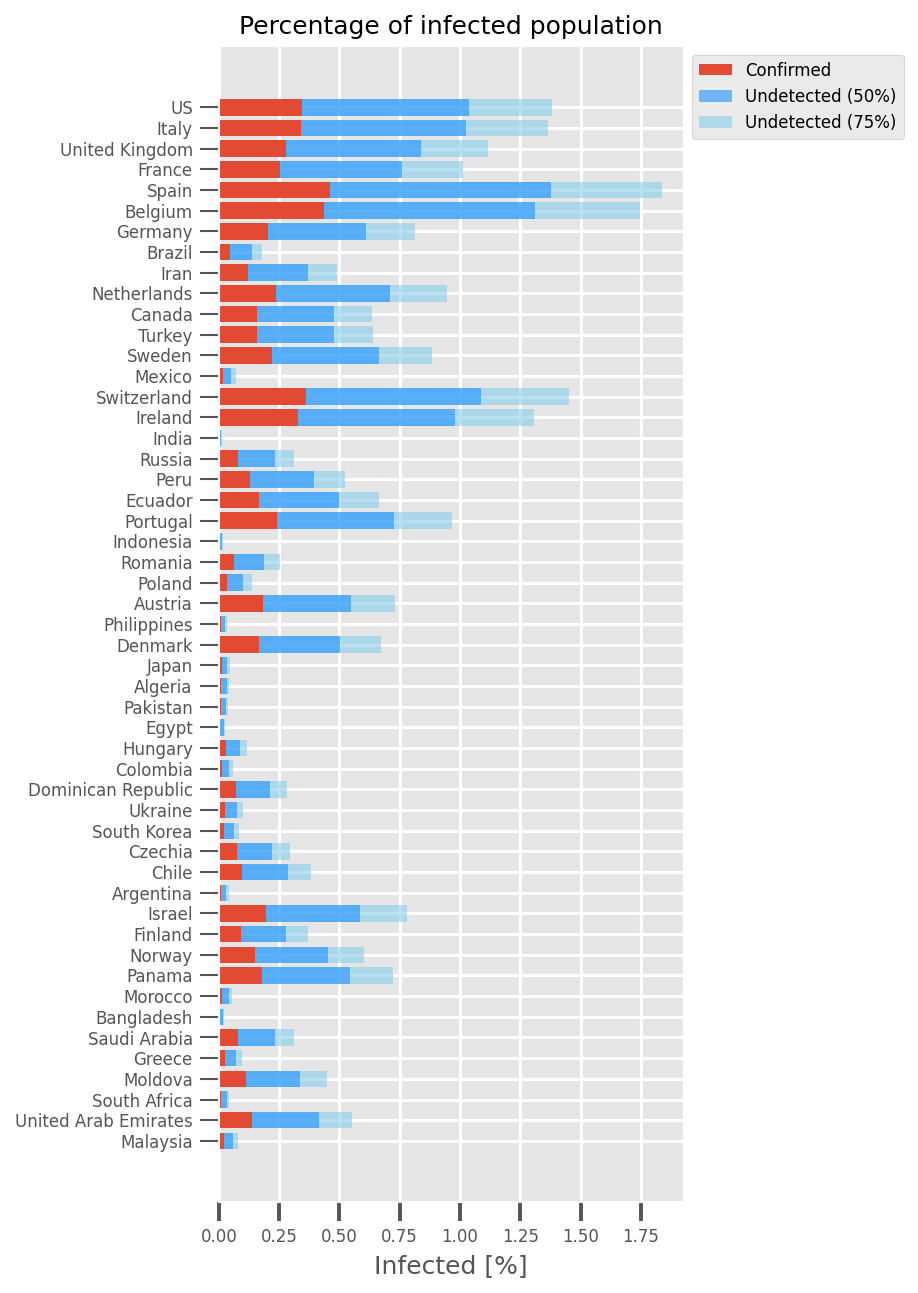

In [11]:
#hide_input
asymp = lambda factor: np.multiply(infected_population_list, factor)

height = len(countries)/5
fig, ax = plt.subplots(1, 1, figsize=(4, height), dpi=150)

# hack for disabling second plot 
axs = []
axs.append(ax)

# axs[1].barh(countries[::-1], deceased_population_list[::-1], color='gray', label='Deceased', alpha=0.8)
# axs[1].set_xlabel("Deceased [%]", fontsize=12)
# axs[1].tick_params(axis='both', which='major', labelsize=8)
# axs[1].set_yticklabels([])
# axs[1].yaxis.set_tick_params(width=1)


axs[0].barh(countries[::-1], infected_population_list[::-1], color='C0', label='Confirmed')
axs[0].barh(countries[::-1], asymp(2)[::-1], left=infected_population_list[::-1], color='dodgerblue', label='Undetected (50%)', ls='--', alpha=0.6,lw=1,zorder=2)
axs[0].barh(countries[::-1], asymp(3)[::-1], left=infected_population_list[::-1], color='skyblue', label='Undetected (75%)', ls='--', alpha=0.6,lw=1)
axs[0].tick_params(axis='both', which='major', labelsize=8)
axs[0].yaxis.set_tick_params(width=1)


plt.title("Percentage of infected population", fontsize=12)
axs[0].set_xlabel("Infected [%]", fontsize=12)
max_value = np.max(asymp(3)[::-1]) + infected_population_list[::-1][np.argmax(asymp(3)[::-1])]
axs[0].legend(bbox_to_anchor=(1, 1.0), fontsize=8)

import matplotlib
bob = matplotlib.transforms.Bbox([[-0.7, height-3.8], [3.5, height-.8]])
plt.savefig("../images/icon_herd_immunity.png", bbox_inches=bob, pad_inches=0.0)

# Extrapolation

We can estimate the time it takes to reach this many infected people by extrapolating what we already have already observed. We don't fit fancy models here or do anything special really but simply take the *30 day average* of the past confirmed cases and assume that the infection rate (or rather the case confirmation rate) stays constant. Then, we can easily calculate, how long it would take for each country to reach 60% of its population. 

As of 25.04.2020, this number for many, if not all, countries is absurdly high. This can be due to do with the fact the outbreak hasn't really started in most places yet since only a tiny amount of the population was infected or that testing capabilities are still very insufficient in many places. 

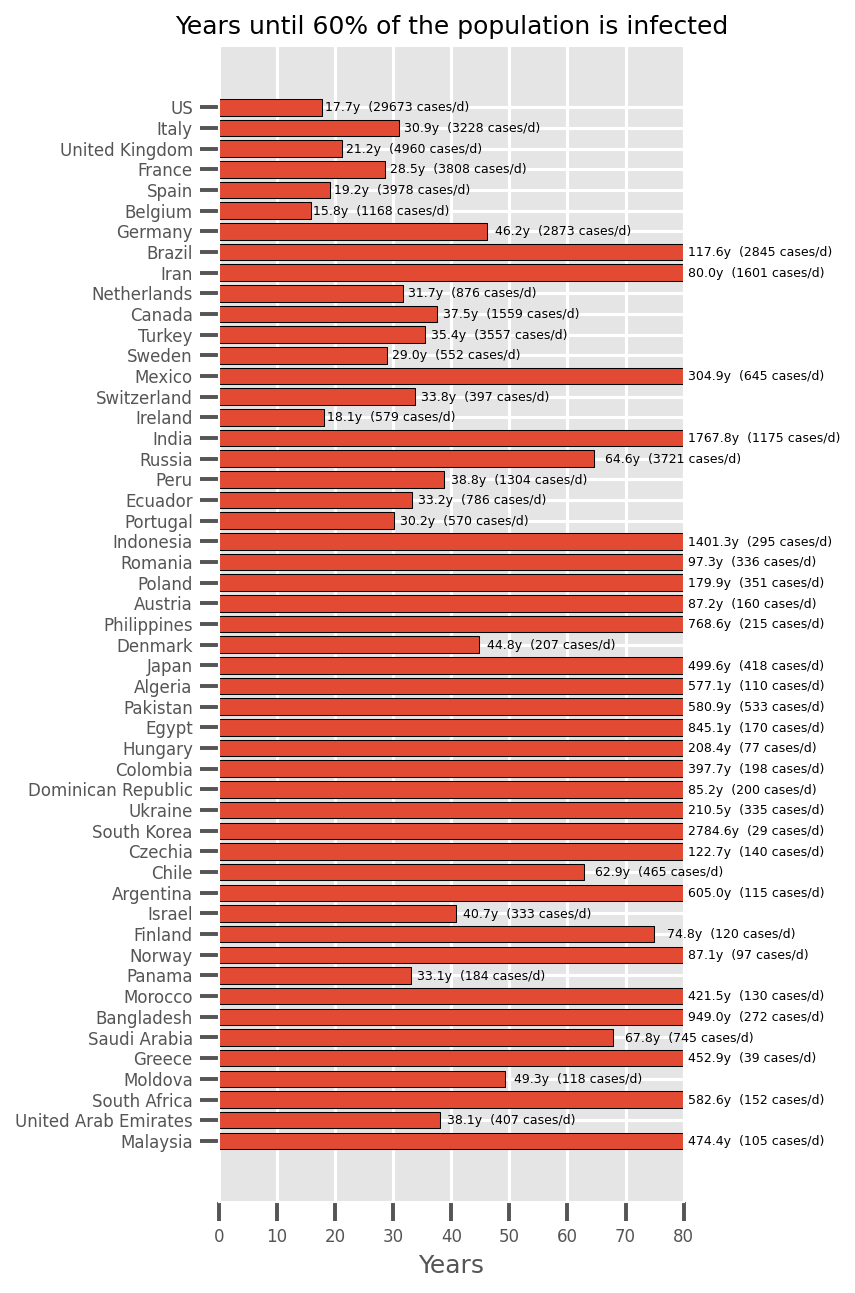

In [12]:
#hide_input
years_until_full_infection_list = np.divide(days_until_full_infection_list, 365)

height = len(countries)/5
fig, axs = plt.subplots(1, 1, figsize=(4, height), dpi=150)
plt.barh(countries[::-1], years_until_full_infection_list[::-1], color='C0', edgecolor='k')

plt.tick_params(axis='both', which='major', labelsize=8)
plt.title(f"Years until {int(HERD_IMMUNITY_THRESHOLD*100)}% of the population is infected", fontsize=12)
plt.xlabel("Years", fontsize=12)

x_thresh = np.median(years_until_full_infection_list)
plt.xlim(0, x_thresh)

for i, c in enumerate(countries[::-1]):
    x_val = years_until_full_infection_list[::-1][i] 
    x_val *= 1.03
    if x_val > x_thresh:
        x_val = x_thresh*1.01
    txt = plt.text(x_val, i-0.2, f"{years_until_full_infection_list[::-1][i]:0.1f}y  ({int(new_cases_mean_list[::-1][i])} cases/d)", fontsize=6, fontweight='regular', color='k')

## Baseline measurements

Here we show the case rate for each country and highlight the last 30 days of confirmed cases that were used as a baseline to project the case rate into the future.

US


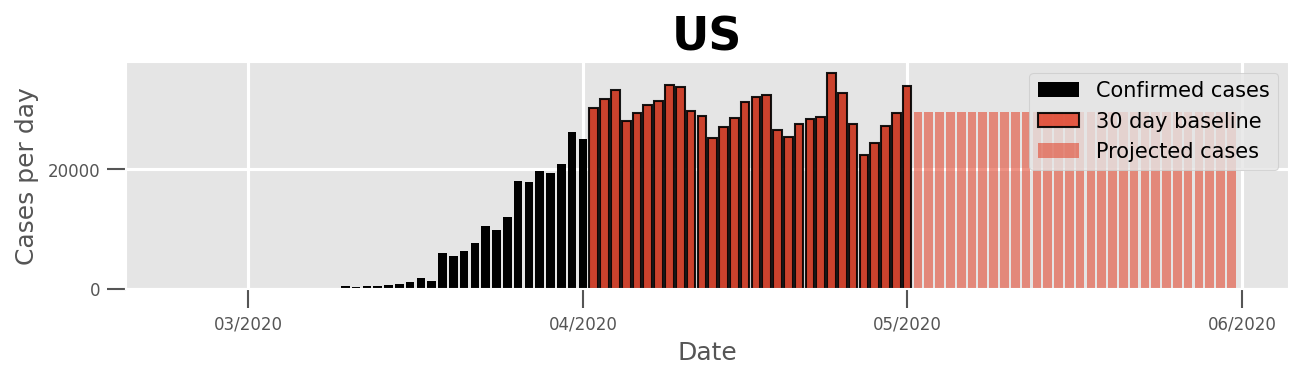

Italy


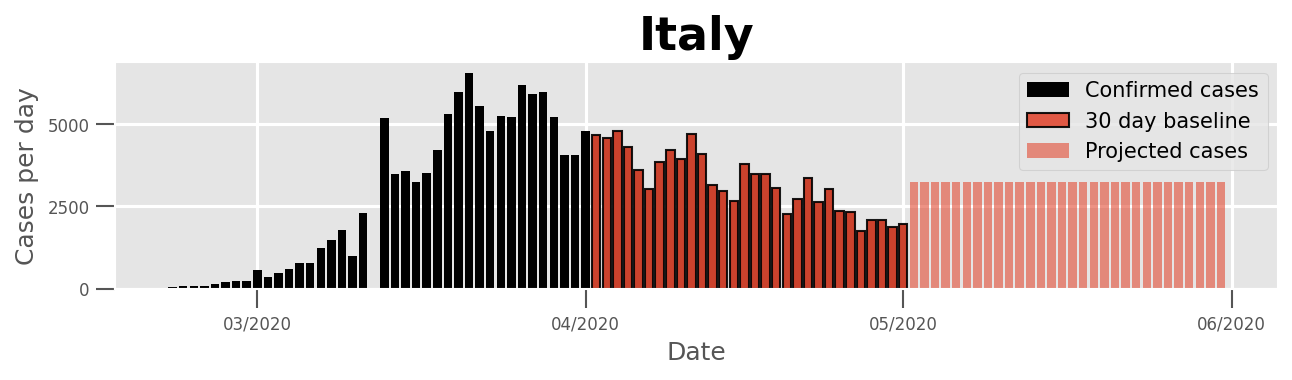

United Kingdom


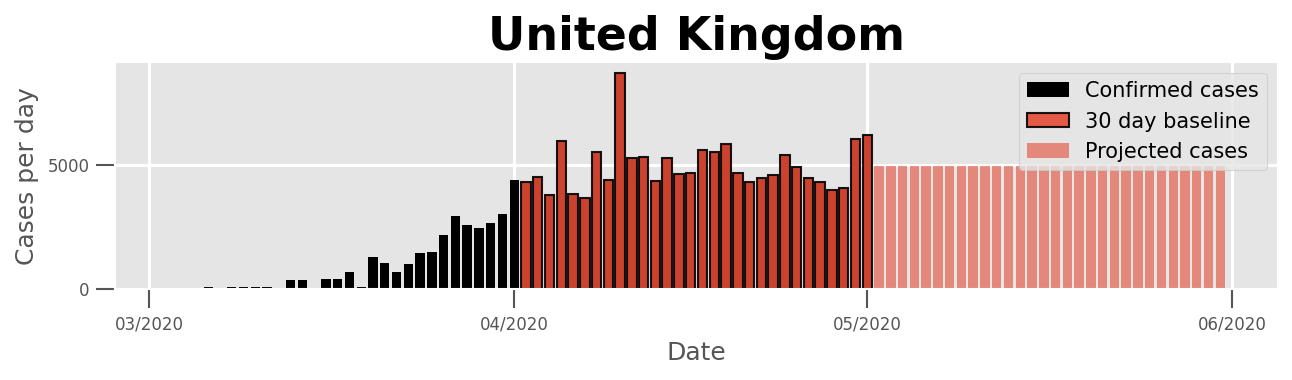

France


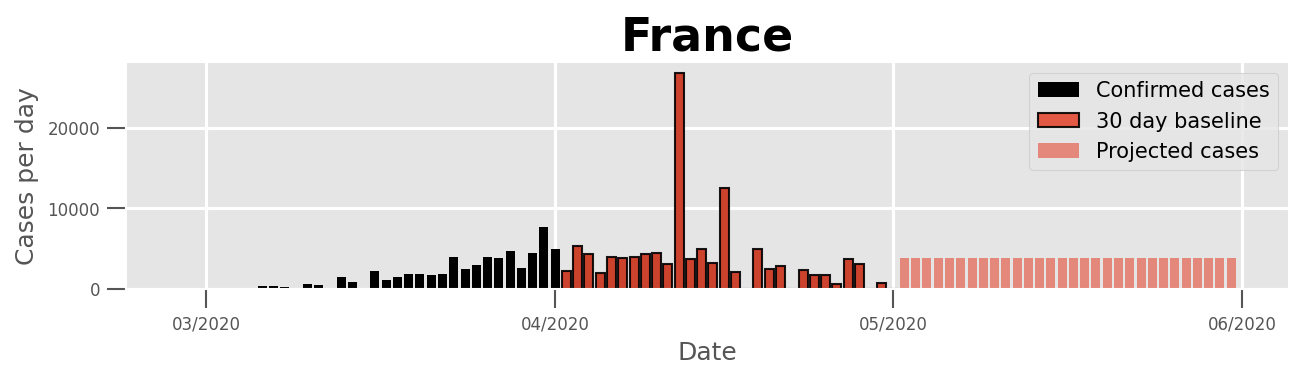

Spain


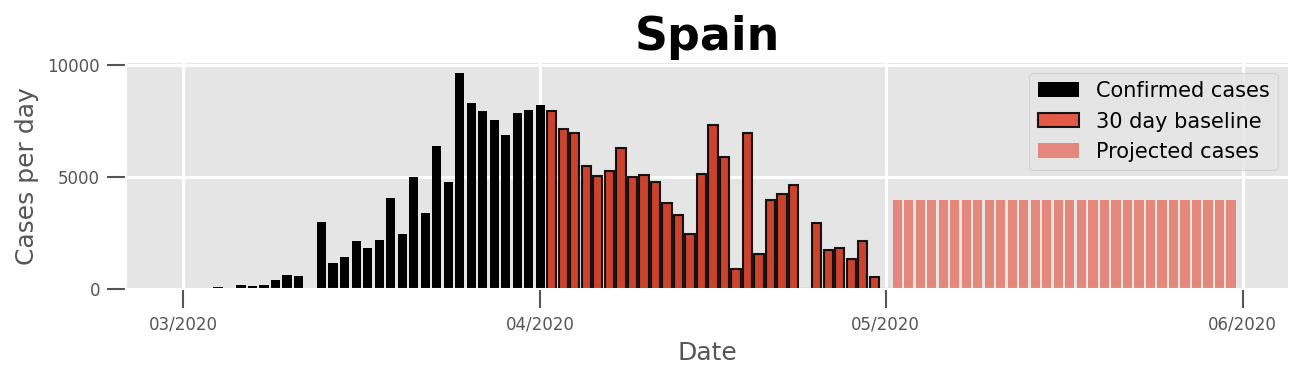

Belgium


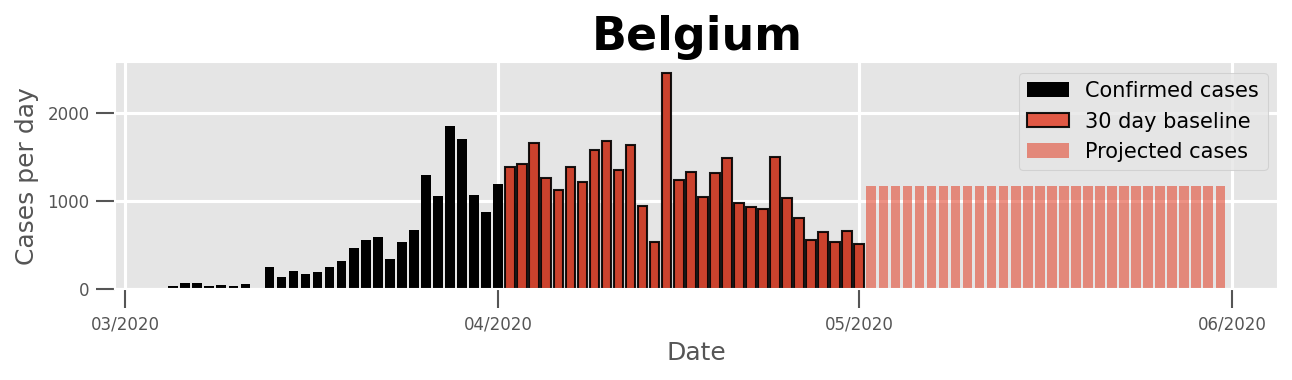

Germany


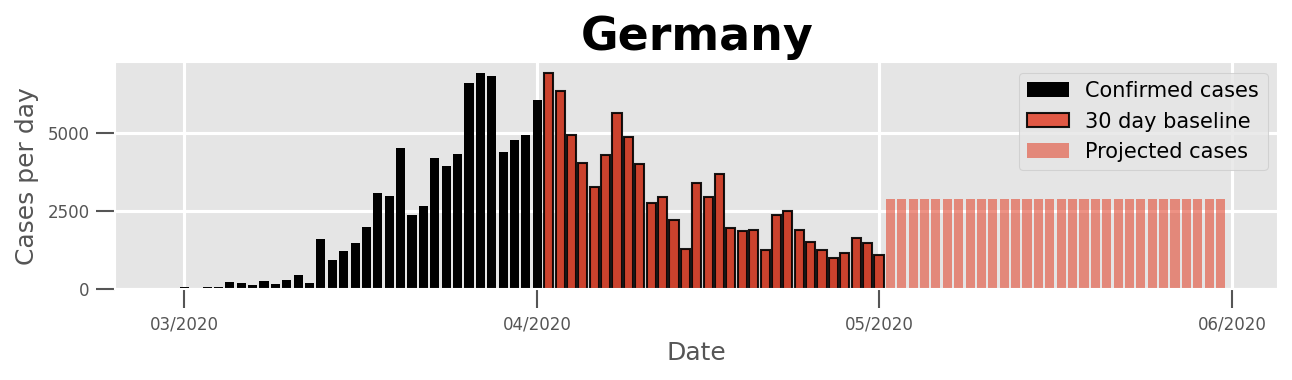

Brazil


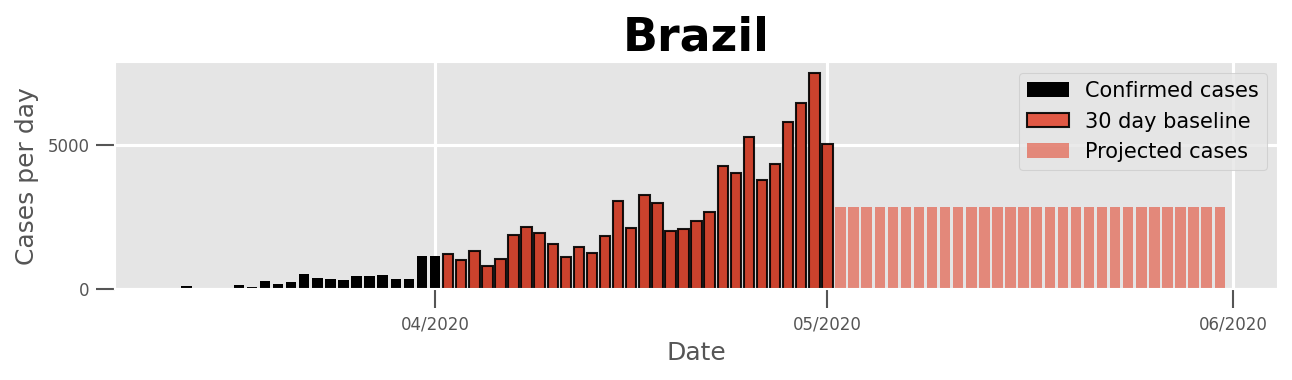

Iran


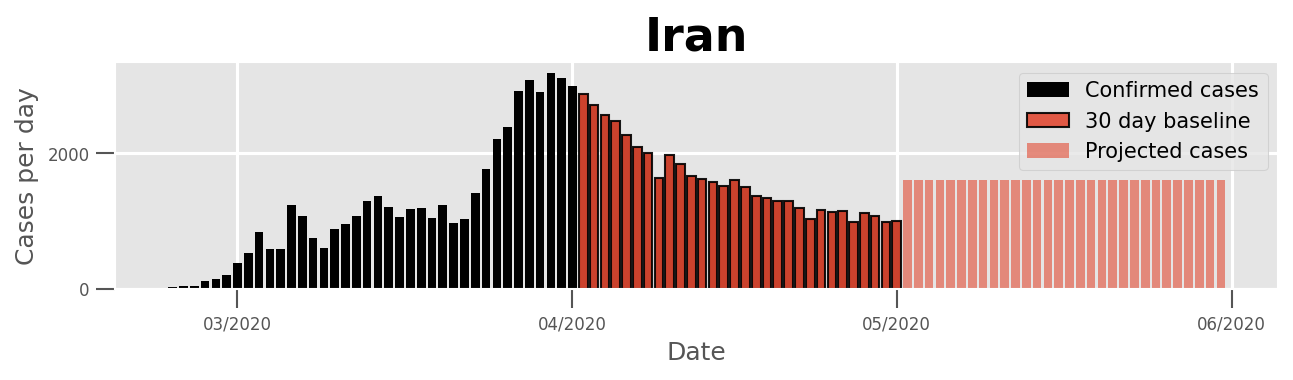

Netherlands


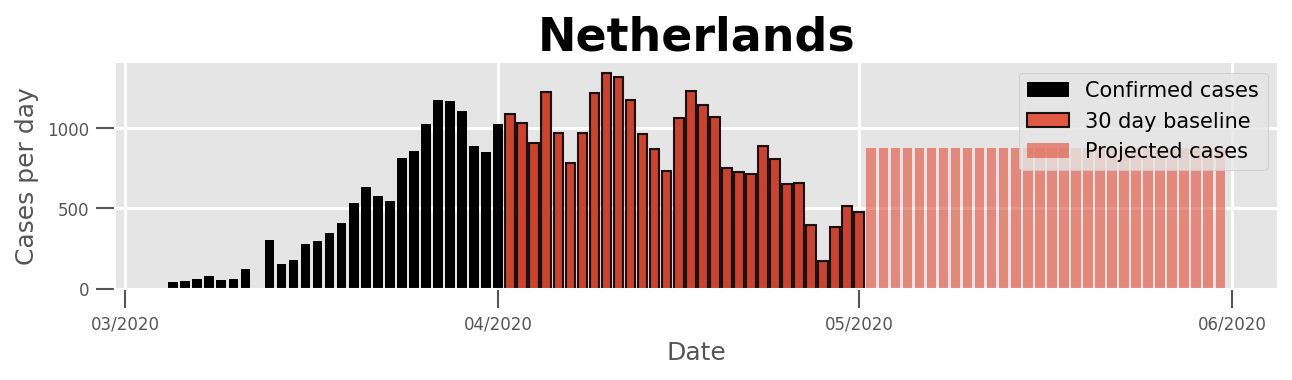

Canada


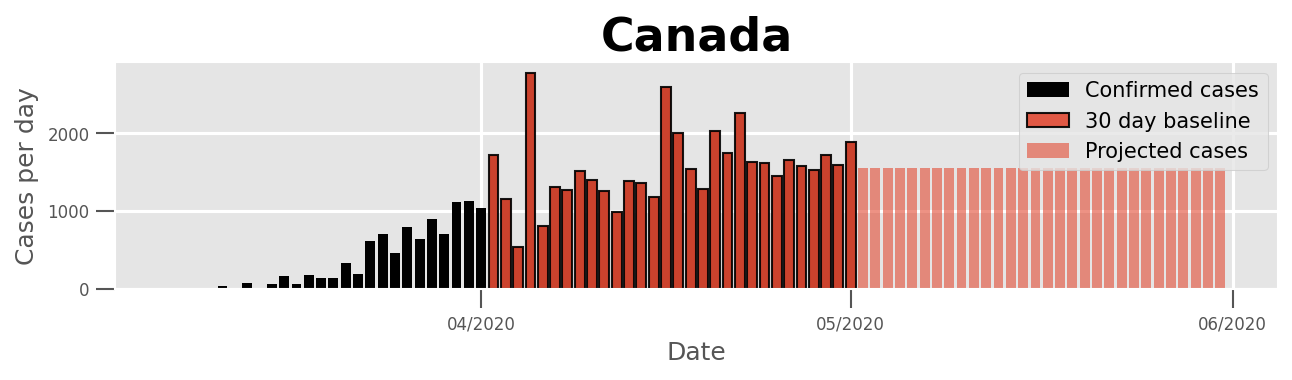

Turkey


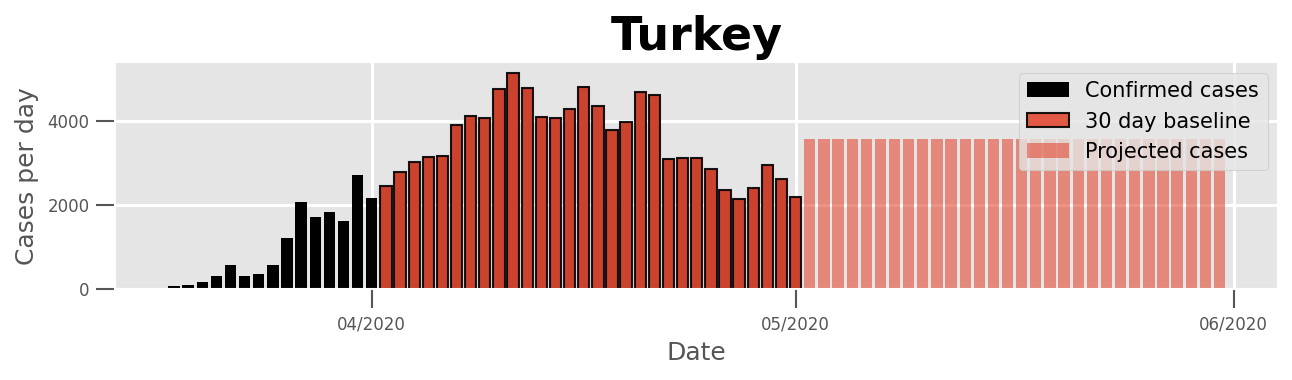

Sweden


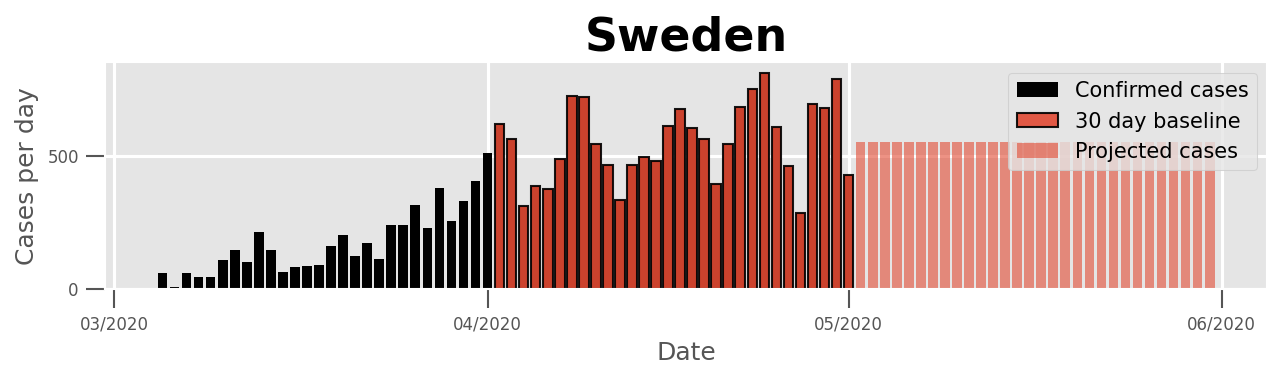

Mexico


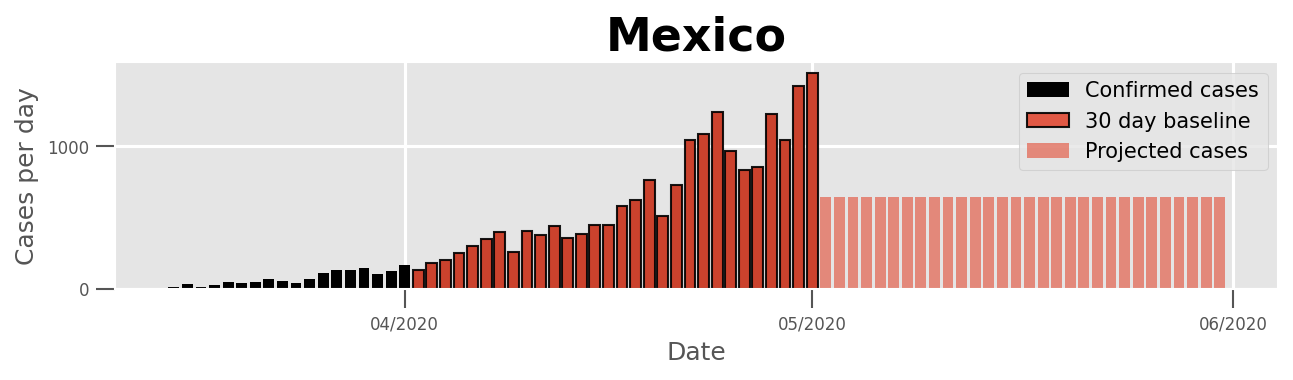

Switzerland


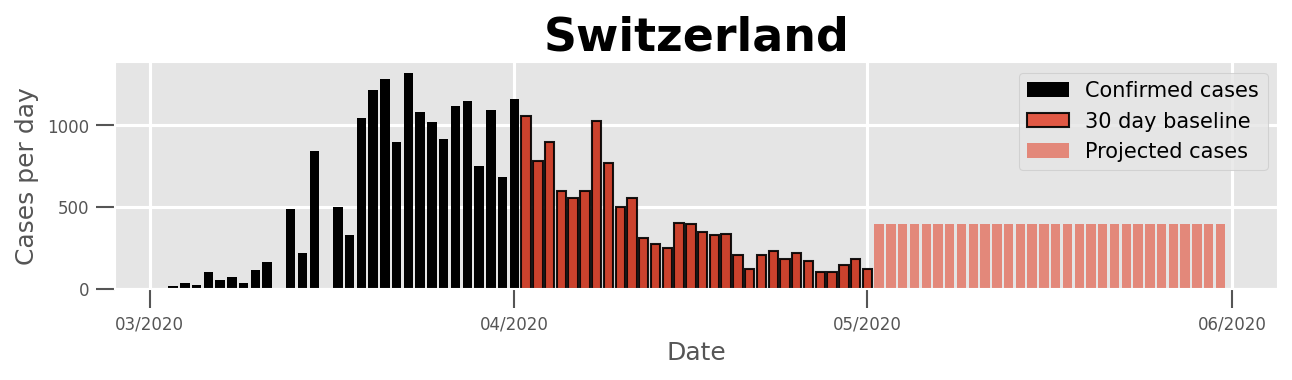

Ireland


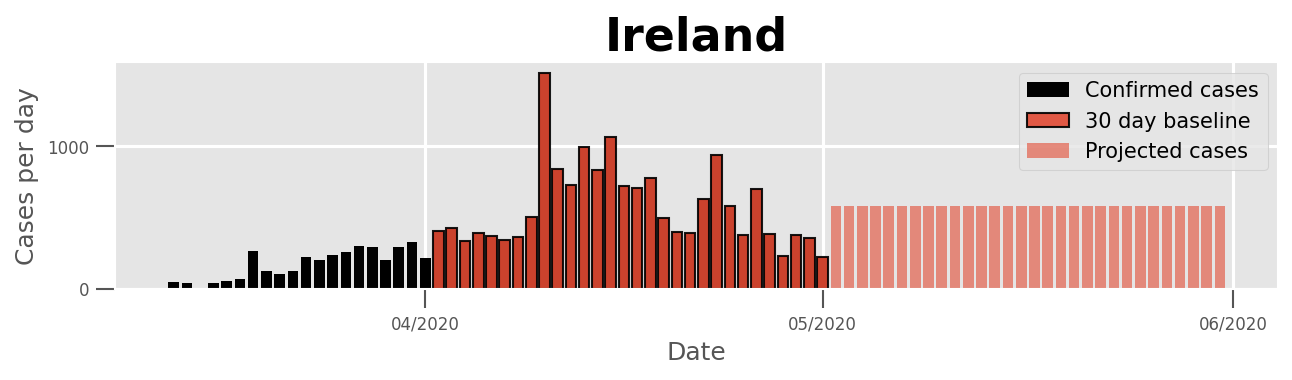

India


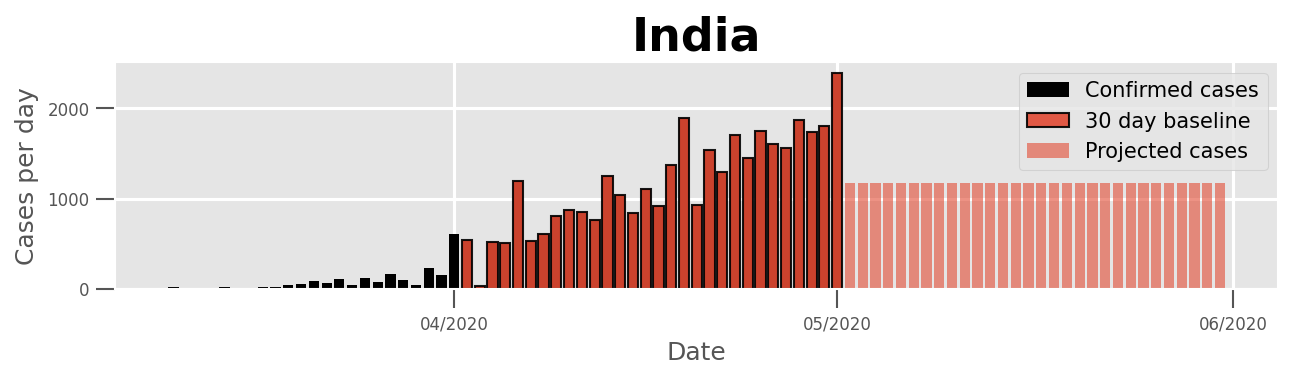

Russia


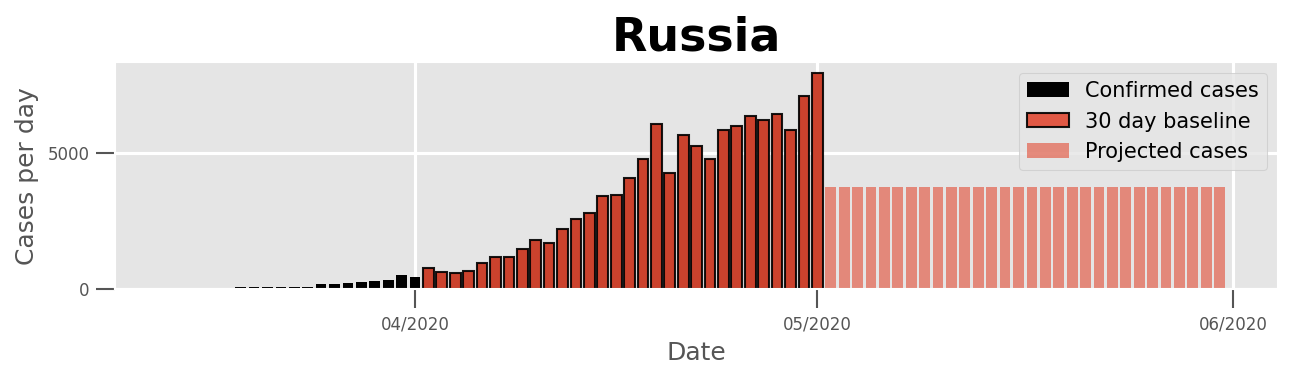

Peru


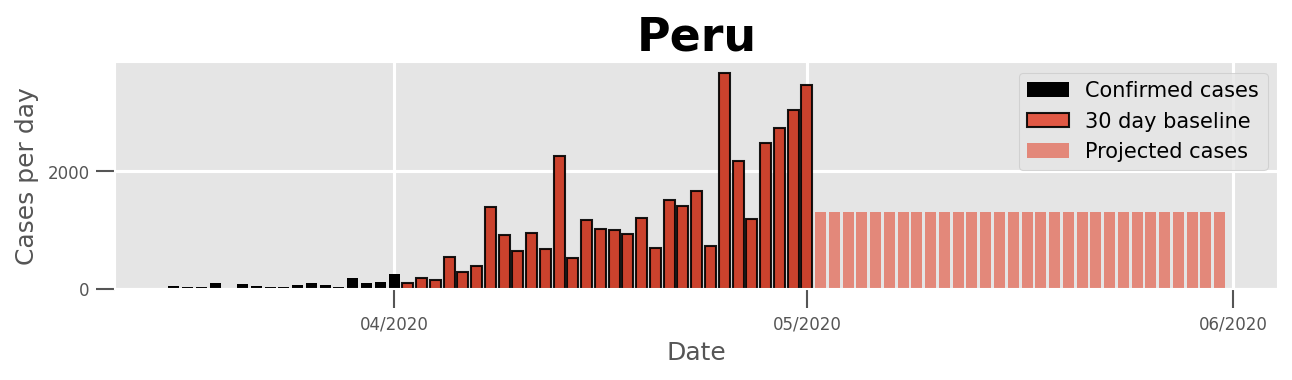

Ecuador


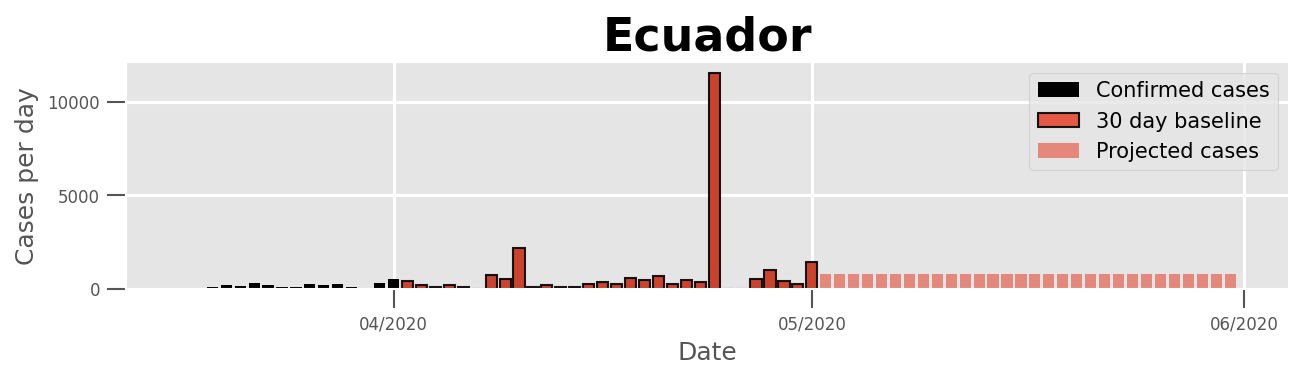

Portugal


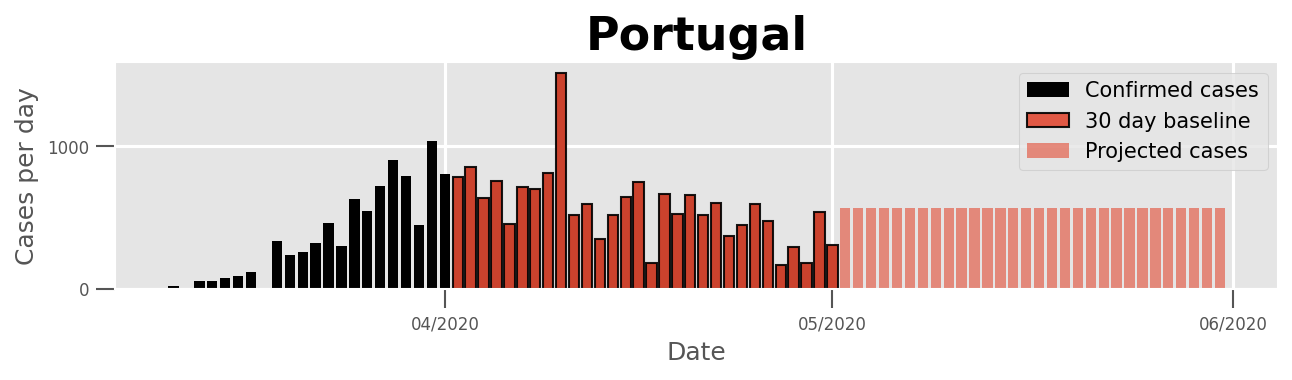

Indonesia


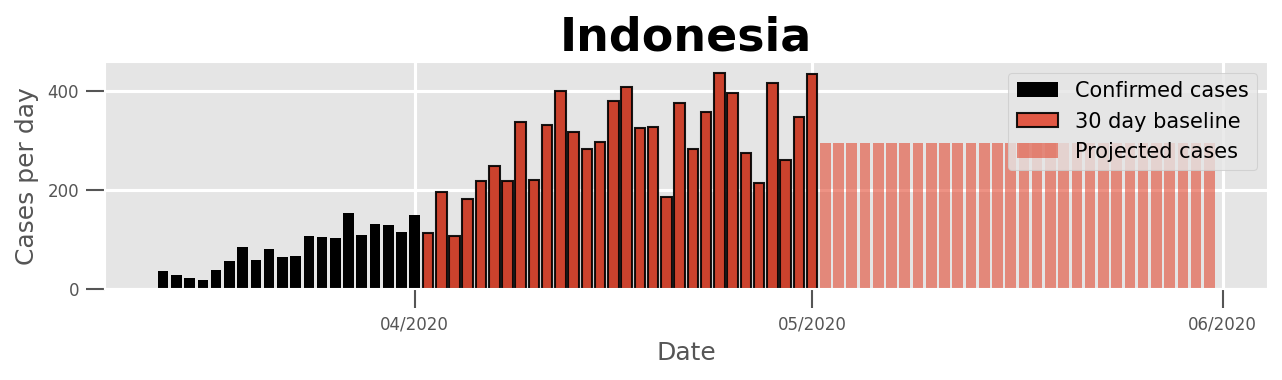

Romania


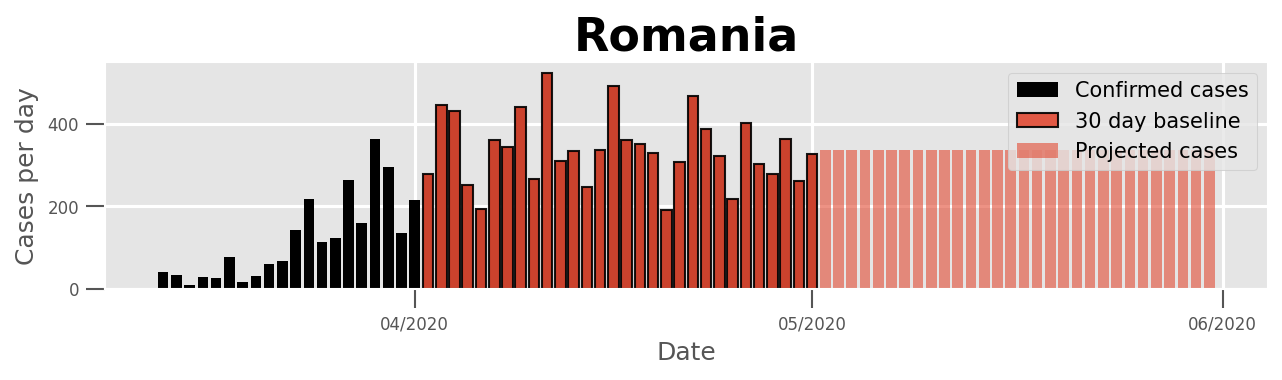

Poland


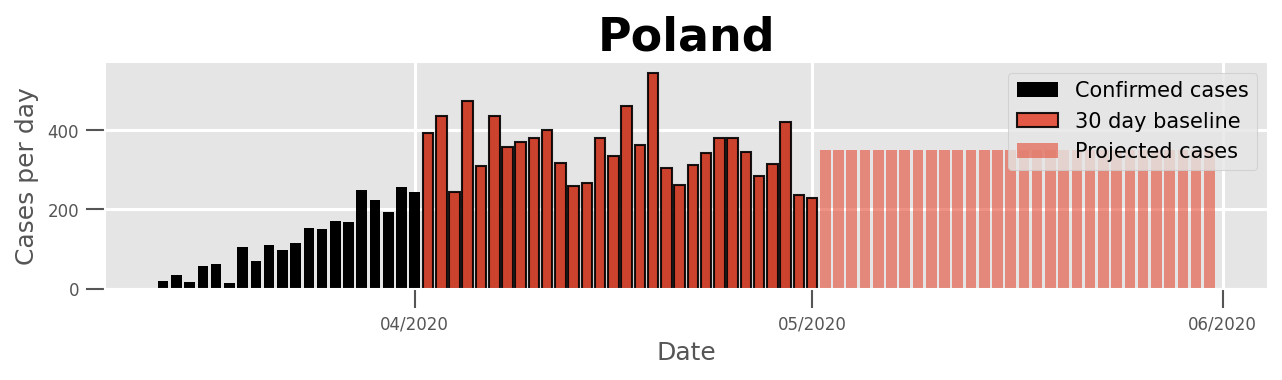

Austria


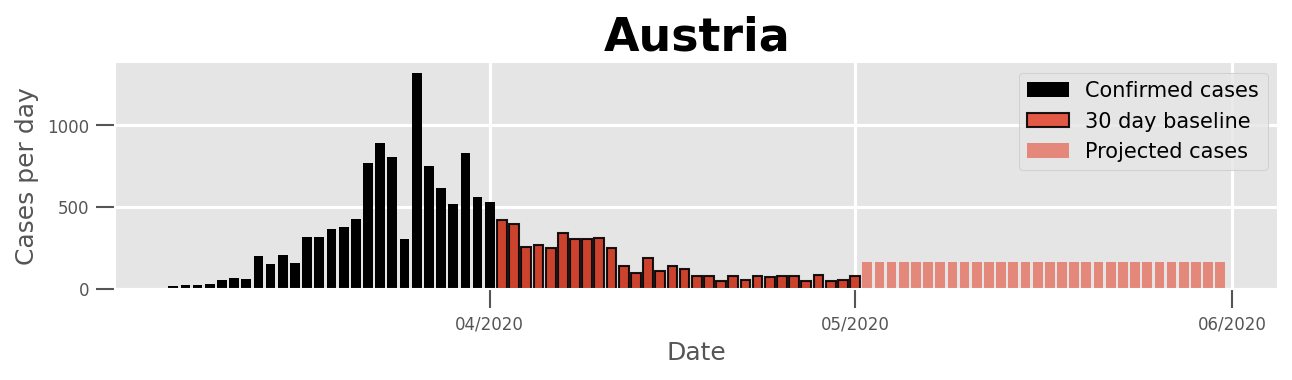

Philippines


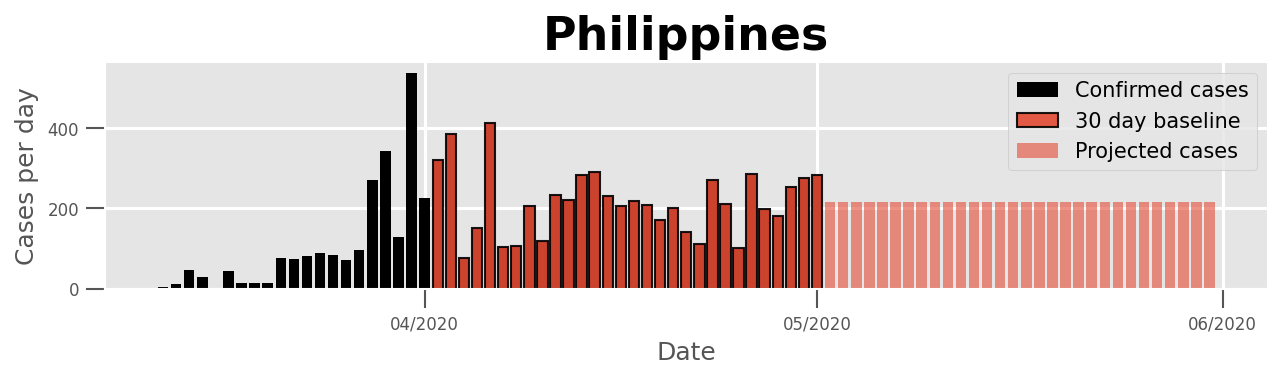

Denmark


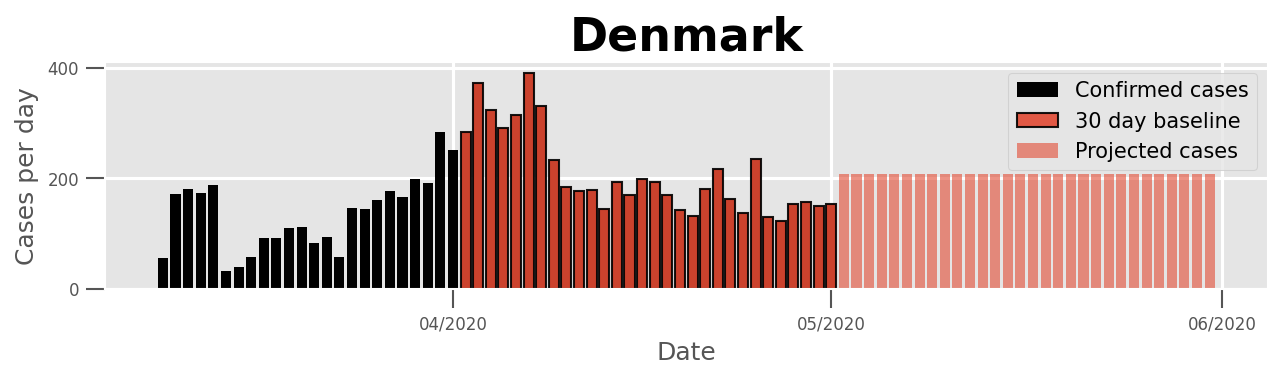

Japan


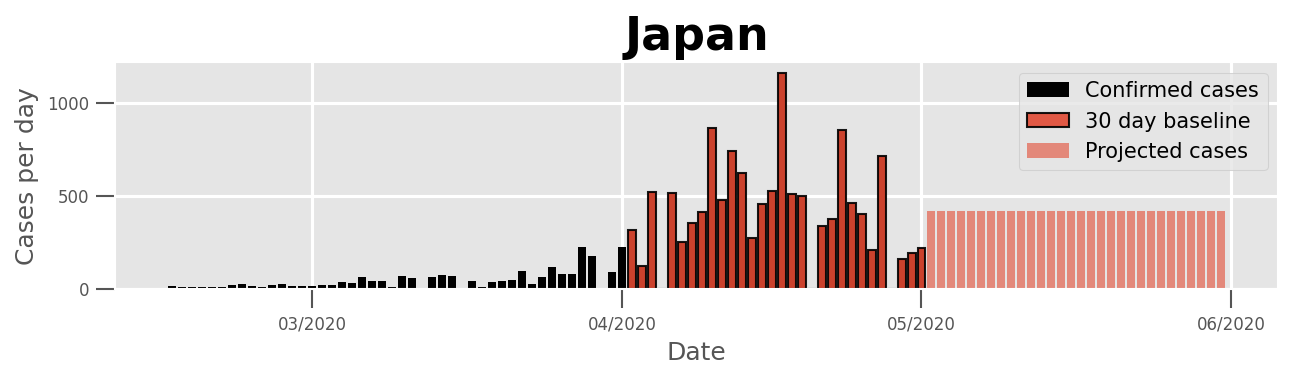

Algeria


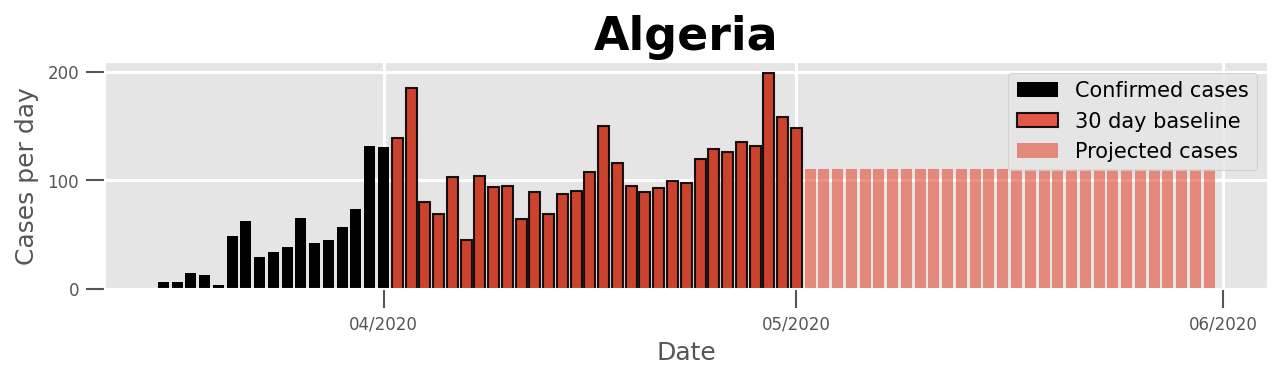

Pakistan


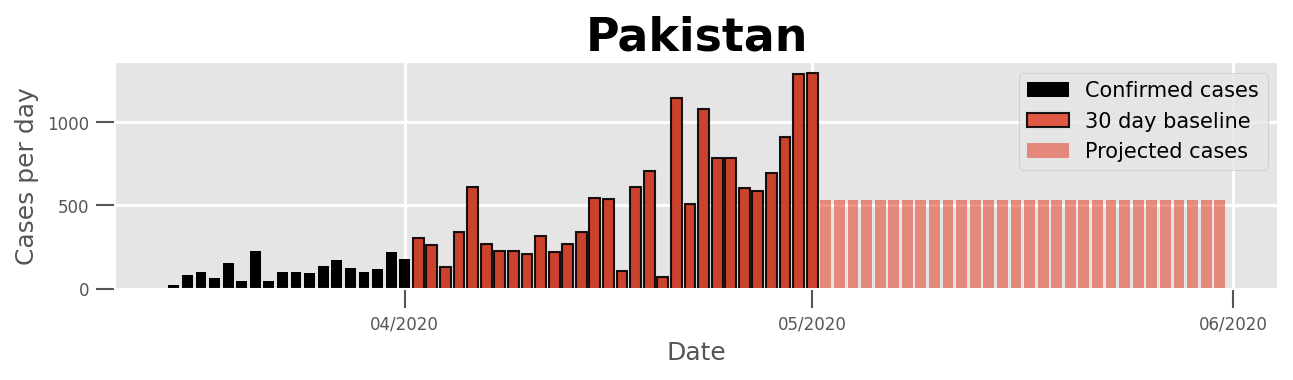

Egypt


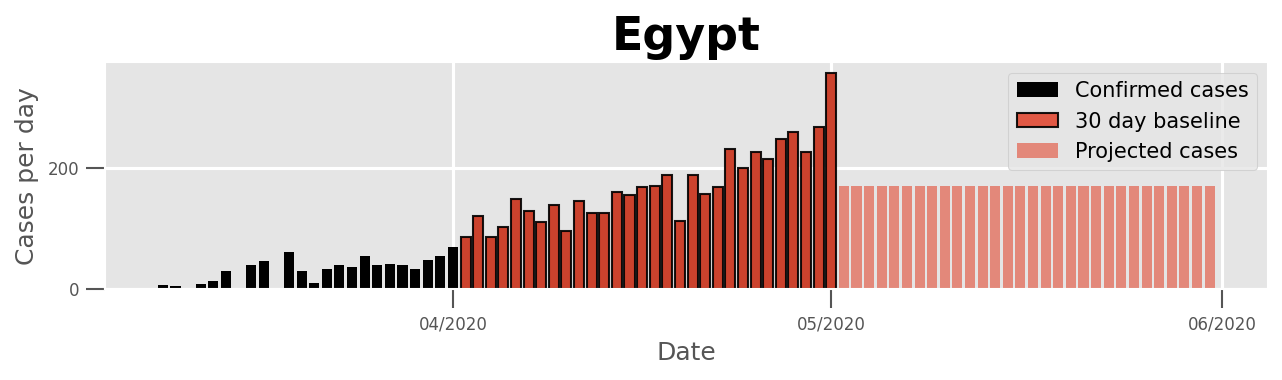

Hungary


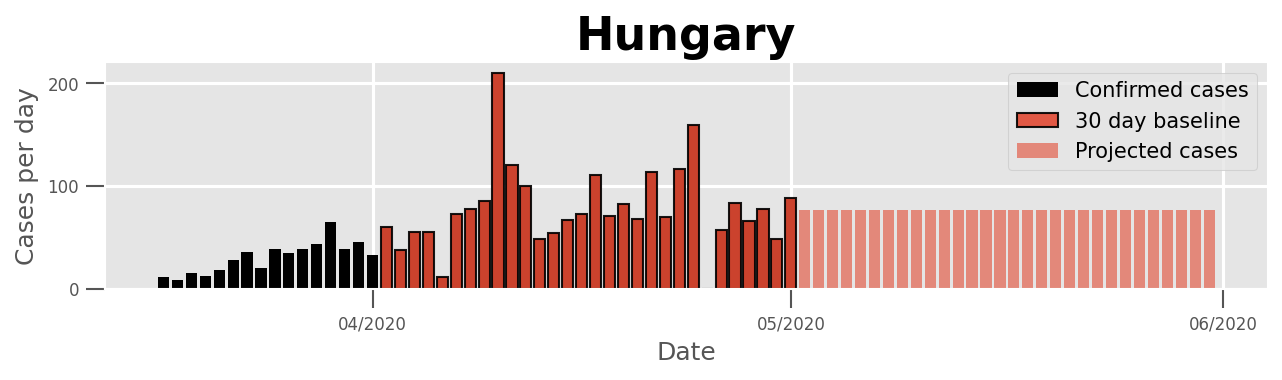

Colombia


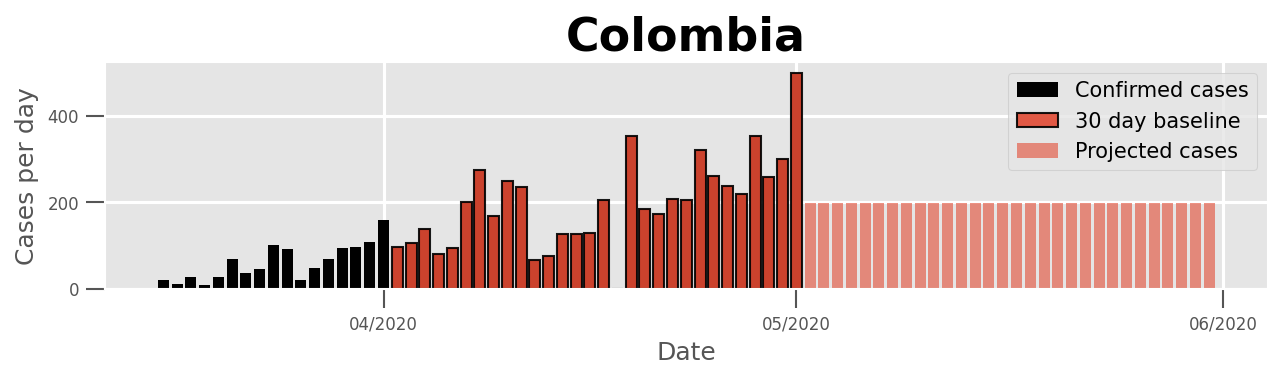

Dominican Republic


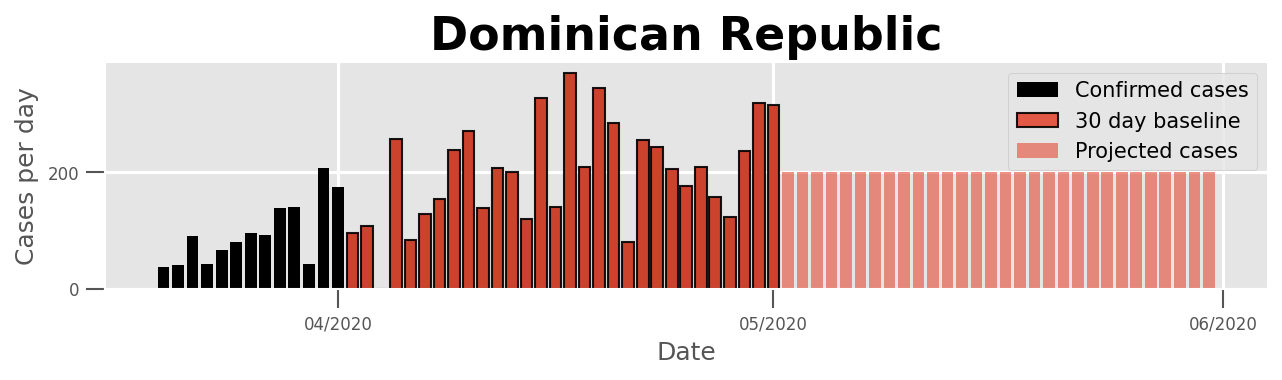

Ukraine


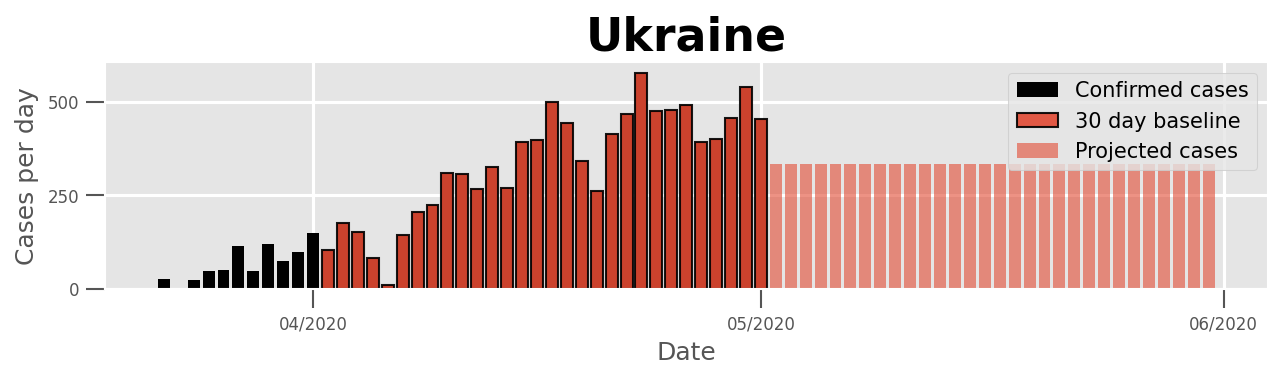

South Korea


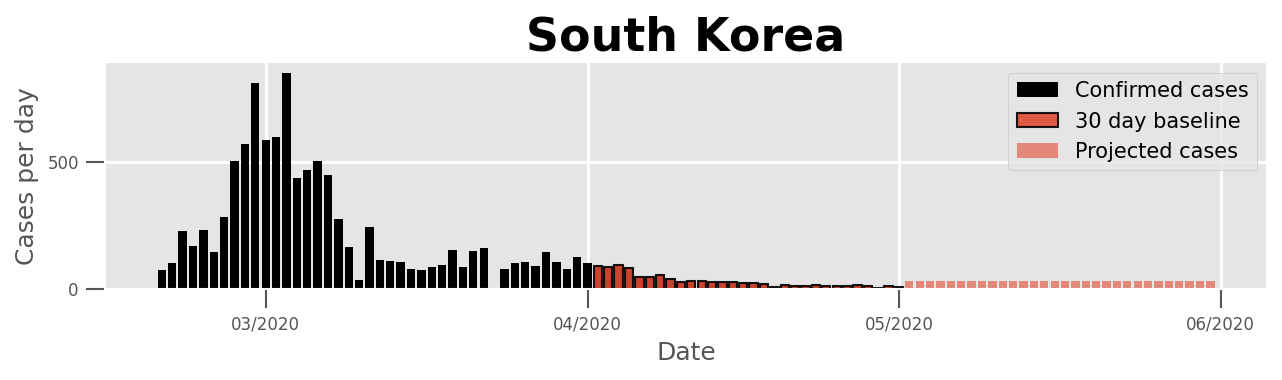

Czechia


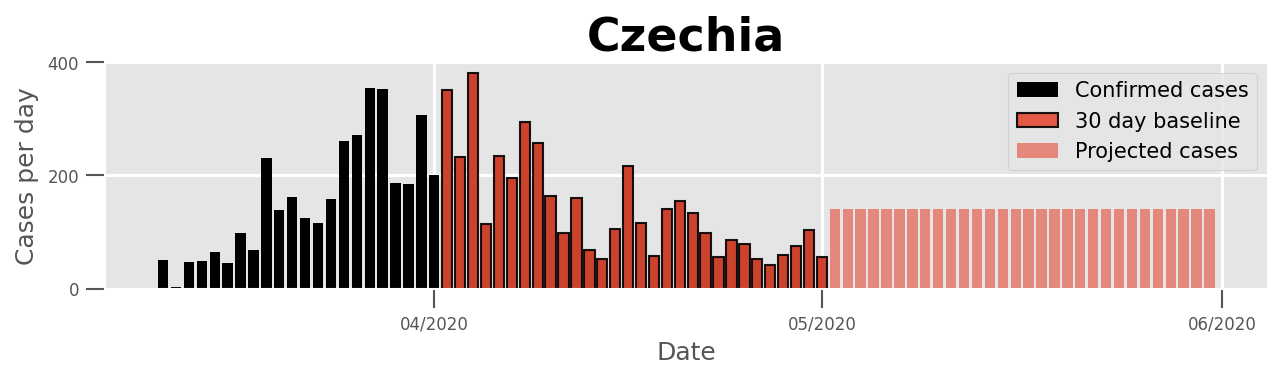

Chile


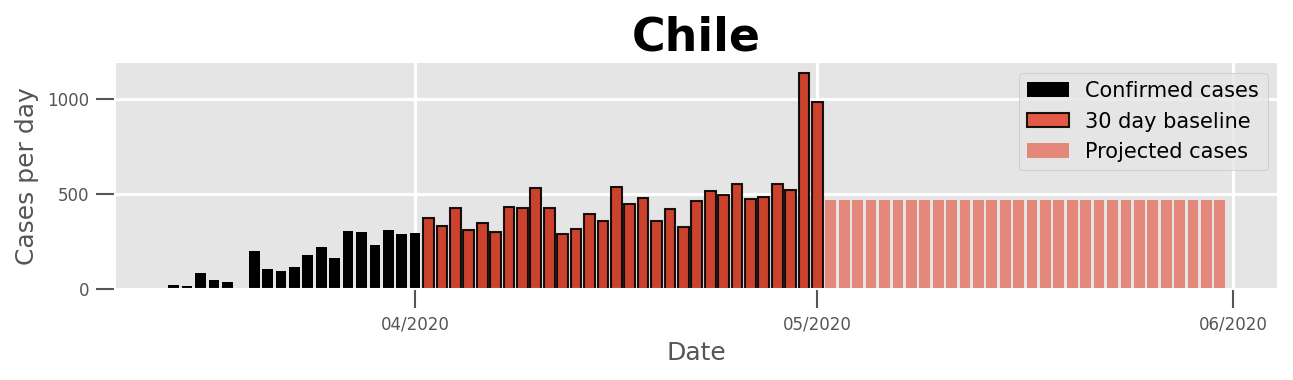

Argentina


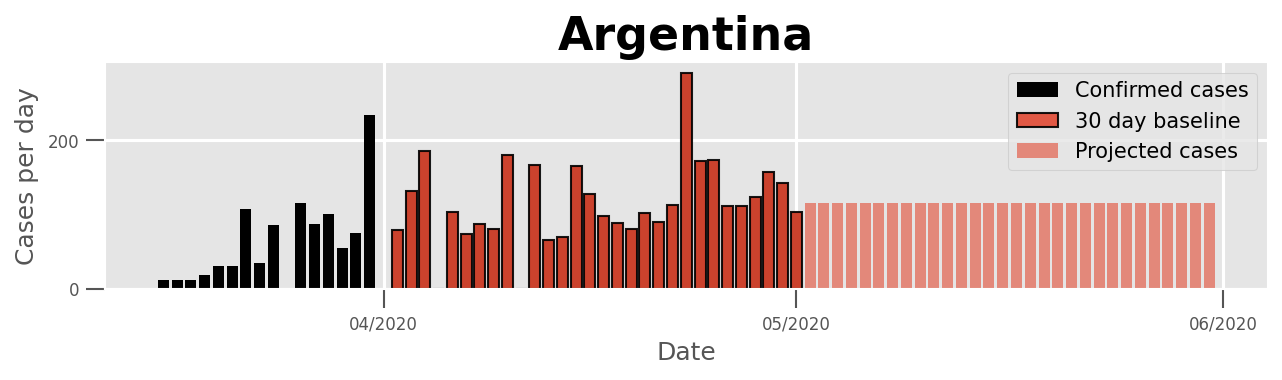

Israel


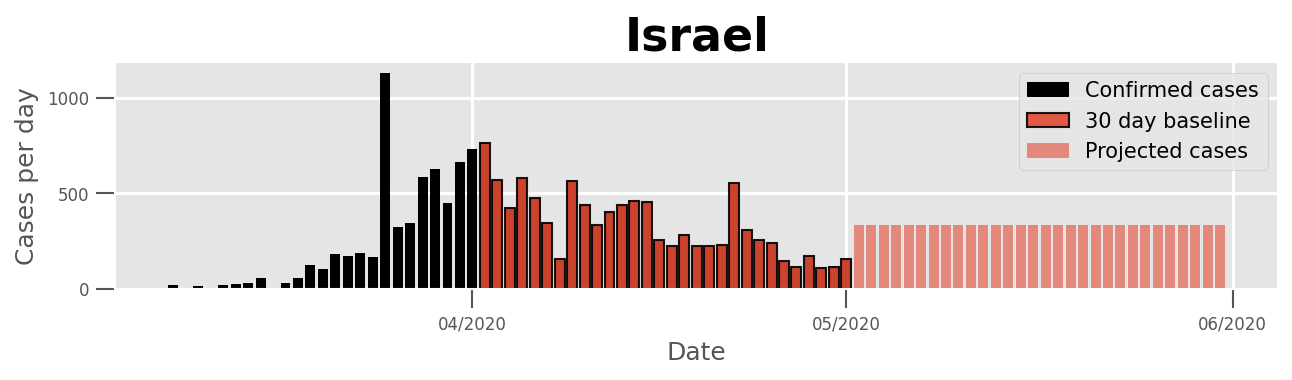

Finland


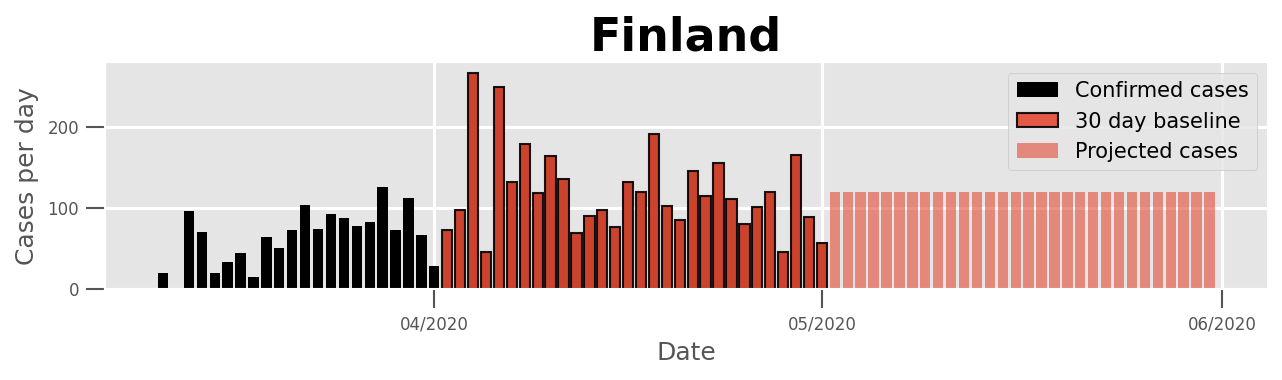

Norway


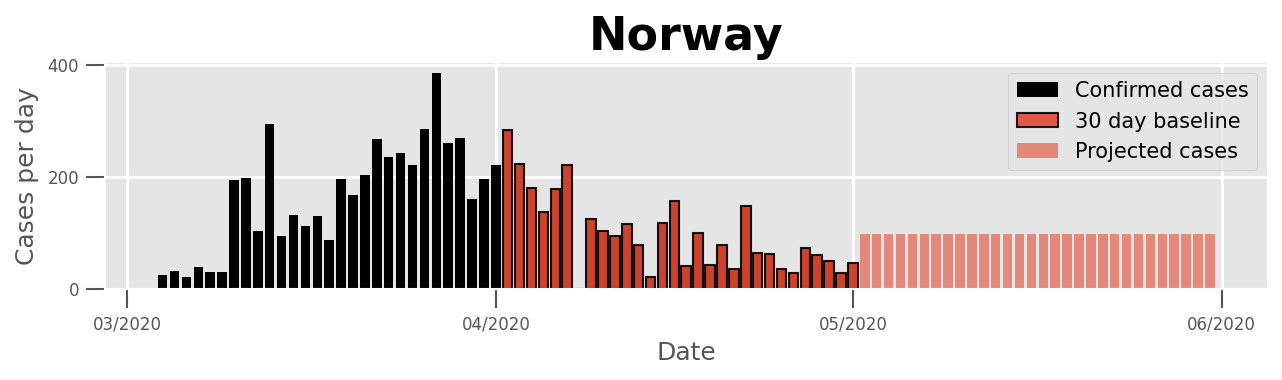

Panama


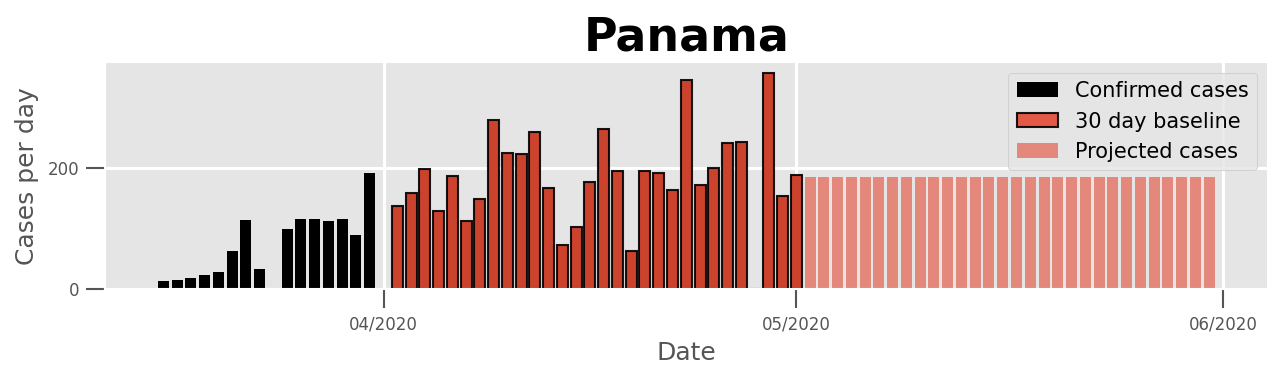

Morocco


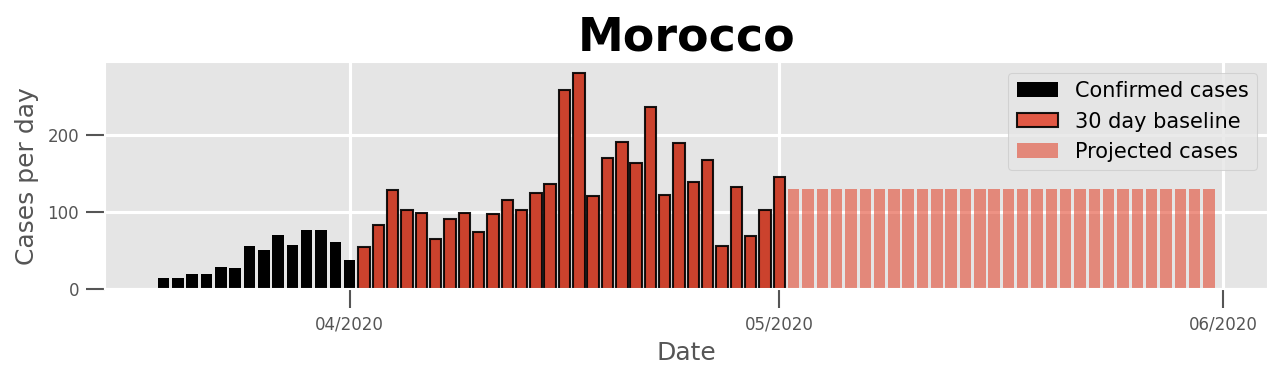

Bangladesh


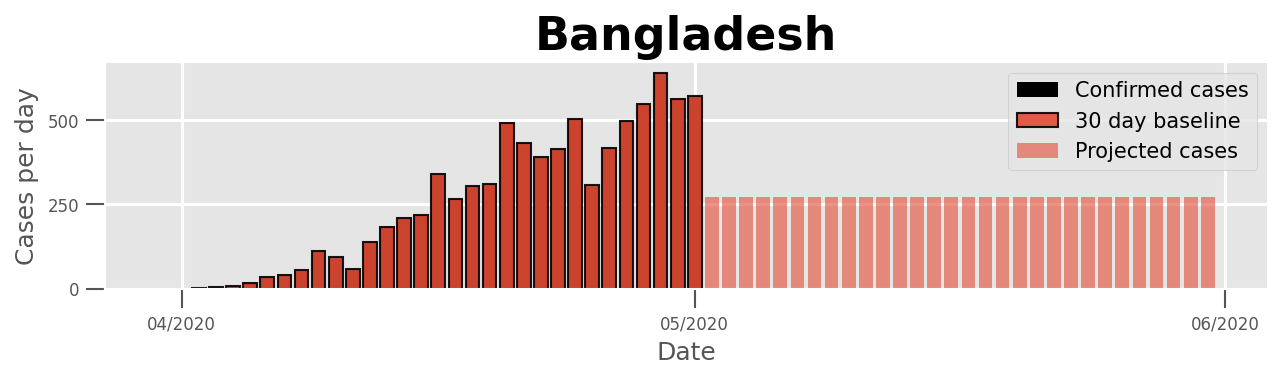

Saudi Arabia


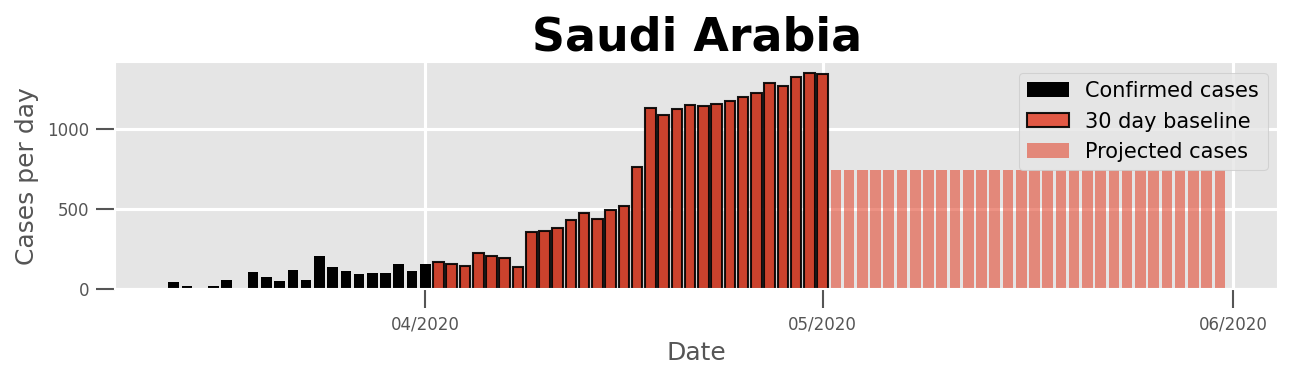

Greece


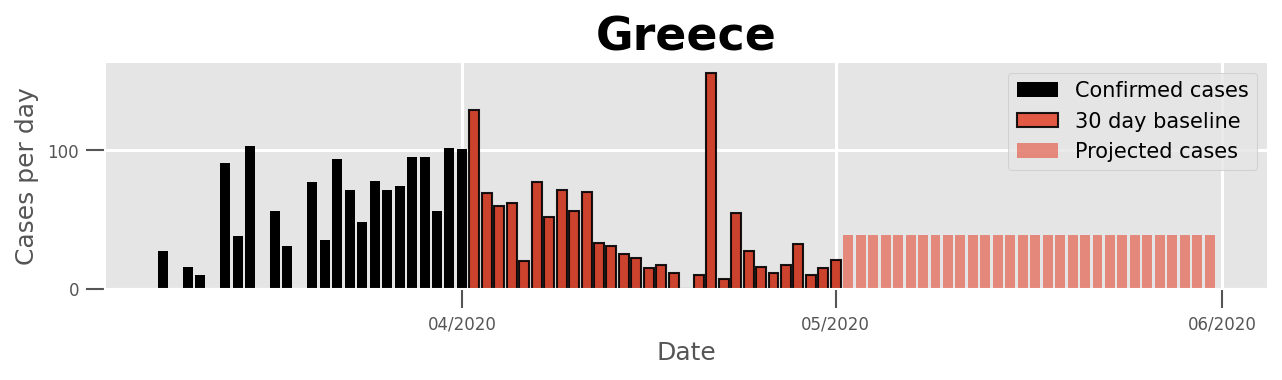

Moldova


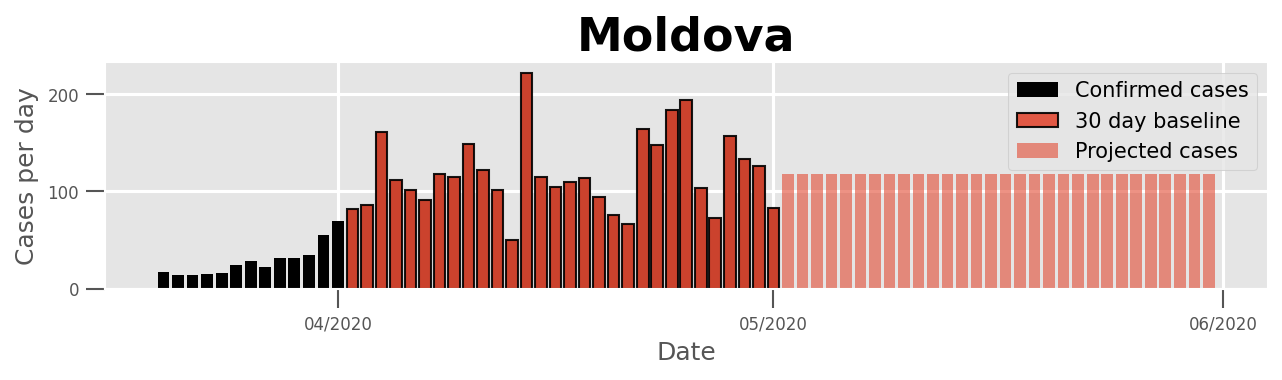

South Africa


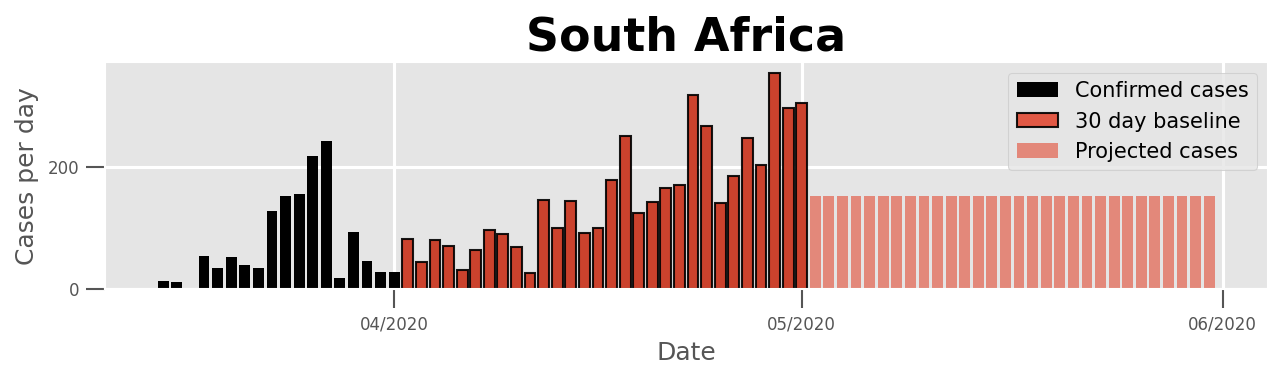

United Arab Emirates


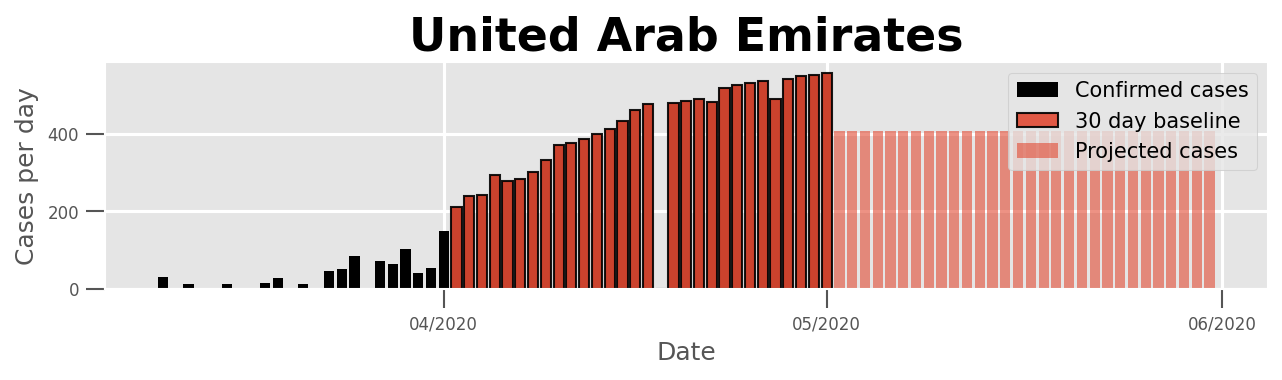

Malaysia


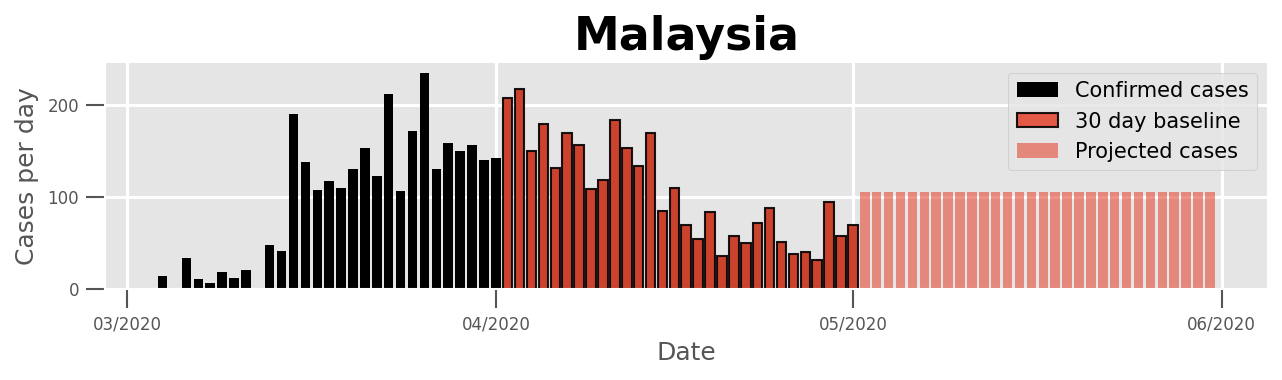

In [13]:
#hide_input
ignore = [] #["China", "Switzerland"]
for i, str_country in enumerate(countries):
    print(f"{str_country}")
    df_cases_country = dff2[dff2['country']==str_country]      

    fig, axs = plt.subplots(1, 1, figsize=(10, 2), dpi=150)
    axs.set_title(f"{str_country}", fontsize=22, fontweight="bold")
    
    axs.bar(df_cases_country.index, df_cases_country.new_confirmed, lw=4, label=f"Confirmed cases", color='k')
    
    fit_cases = df_cases_country.iloc[-MEAN_CASES_DAYS:]
    axs.bar(fit_cases.index, fit_cases.new_confirmed, lw=1, edgecolor='k', label=f"{MEAN_CASES_DAYS} day baseline", color='C0', alpha=0.9)
    
    
    axs.xaxis.set_major_locator(mdates.MonthLocator(interval=1))   #to get a tick every x months
    axs.xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y')) 
    
    days_to_go = 30
    projected_cases_per_day = int(new_cases_mean_list[i])
    last_date = df_cases_country.iloc[[-1]].index + datetime.timedelta(days=1)
    future_cases = pd.DataFrame(index=pd.date_range(last_date[0], periods=int(days_to_go), freq='D'), columns=['new_confirmed'])
    future_cases['new_confirmed'] = projected_cases_per_day


    axs.bar(future_cases.index, future_cases.new_confirmed, lw=4, color='C0', label=f"Projected cases", alpha=0.6)


    axs.legend(loc=1, fontsize=10)

    plt.xlabel(f"Date", fontsize=12)
    axs.xaxis.set_tick_params(width=1)
    axs.yaxis.set_tick_params(width=1)
    plt.xticks(rotation=0, fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    axs.set_ylabel(f"Cases per day", fontsize=12)
    plt.show()
